In [1]:
# With the same augmentation, we are going to try vgg and resnet

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
### Preparing the dataframe 
import pandas as pd
import glob
from pathlib import Path
import matplotlib.pyplot as plt 





In [4]:

#/Users/krish/Library/CloudStorage/GoogleDrive-krishthephysicist@gmail.com/My Drive/ljmu/1.data
root_path =  r'/Users/krish/ljmu/'
result_root = root_path + '3.results/06112022-tiling+augmentation/'
Path(result_root).mkdir(parents=True, exist_ok=True)

# # Incase you run in colab
# root_path =  r'/content/drive/MyDrive/ljmu/'
# result_root = root_path + '3.results/06112022-VGGNet/'
# Path(result_root).mkdir(parents=True, exist_ok=True)

In [5]:

df_true = pd.DataFrame(columns = ['name','flag'])
df_false = pd.DataFrame(columns = ['name','flag'])

df_true['name'] = glob.glob(root_path+'1.data/sampletiled/ts/*.jpg')
df_true.flag = 1

df_false['name'] = glob.glob(root_path+'1.data/sampletiled/false/*.jpg')
df_false.flag = 0

df = df_true.append(df_false)

df['flag'] = df.flag.apply(lambda x: str(x)) # used the qubit format
df
# The number of rows is finally matching with what I had on local => Yebba all data uploaded successfullly

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_27946/1957794748.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_true.append(df_false)


,name,flag
0,/Users/krish/ljmu/1.data/sampletiled/ts/905_0_...,1
1,/Users/krish/ljmu/1.data/sampletiled/ts/889_0_...,1
2,/Users/krish/ljmu/1.data/sampletiled/ts/1434_0...,1
3,/Users/krish/ljmu/1.data/sampletiled/ts/5708_0...,1
4,/Users/krish/ljmu/1.data/sampletiled/ts/100_0_...,1
...,...,...
3870,/Users/krish/ljmu/1.data/sampletiled/false/238...,0
3871,/Users/krish/ljmu/1.data/sampletiled/false/197...,0
3872,/Users/krish/ljmu/1.data/sampletiled/false/198...,0
3873,/Users/krish/ljmu/1.data/sampletiled/false/474...,0


In [6]:
# Generator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = df['flag']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 5317 validation 1773


In [7]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [8]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'name', y_col = 'flag', class_mode='binary', target_size=(224 , 224), batch_size=32)

Found 5317 validated image filenames belonging to 2 classes.
Found 1773 validated image filenames belonging to 2 classes.


### Strating with vggnet

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

In [10]:
# Why I have this as false : https://stackoverflow.com/questions/46036522/defining-model-in-keras-include-top-true
# So that I can list out the number of classes that I have
vgg_16 = tf.keras.applications.vgg16.VGG16(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model = Sequential()
model.add(vgg_16)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))

model.add(Dense(1024, activation="relu"))
model.add(Dense(512, activation="relu"))



model.add(Dense(1, activation="sigmoid" , name="classification"))

Metal device set to: Apple M1


2022-11-08 13:26:29.456925: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-08 13:26:29.457137: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                        

In [12]:
class_weight = {0:1.,1:1.}
history = model.fit(train_generator, validation_data = valid_generator, epochs = 30, class_weight=class_weight)

Epoch 1/30


2022-11-08 13:26:30.266381: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-08 13:26:30.563096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.5245

2022-11-08 13:32:57.249885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


167/167 [==============================] - 426s 3s/step - loss: 0.6907 - accuracy: 0.5245 - val_loss: 0.6860 - val_accuracy: 0.5465
Epoch 2/30
167/167 [==============================] - 464s 3s/step - loss: 0.6837 - accuracy: 0.5465 - val_loss: 0.6789 - val_accuracy: 0.5465
Epoch 3/30
167/167 [==============================] - 479s 3s/step - loss: 0.6763 - accuracy: 0.5522 - val_loss: 0.6693 - val_accuracy: 0.5601
Epoch 4/30
167/167 [==============================] - 507s 3s/step - loss: 0.6680 - accuracy: 0.6150 - val_loss: 0.6590 - val_accuracy: 0.6650
Epoch 5/30
167/167 [==============================] - 475s 3s/step - loss: 0.6586 - accuracy: 0.6408 - val_loss: 0.6480 - val_accuracy: 0.6588
Epoch 6/30
167/167 [==============================] - 459s 3s/step - loss: 0.6486 - accuracy: 0.6455 - val_loss: 0.6366 - val_accuracy: 0.6644
Epoch 7/30
167/167 [==============================] - 467s 3s/step - loss: 0.6352 - accuracy: 0.6579 - val_loss: 0.6178 - val_accuracy: 0.6830
Epoch 8/30

In [13]:
model.save(result_root+'vgg16_after_tiling+augmentation_10epochs')

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/06112022-tiling+augmentation/vgg16_after_tiling+augmentation_10epochs/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/06112022-tiling+augmentation/vgg16_after_tiling+augmentation_10epochs/assets


56/56 - 51s - loss: 0.3431 - accuracy: 0.8567 - 51s/epoch - 906ms/step


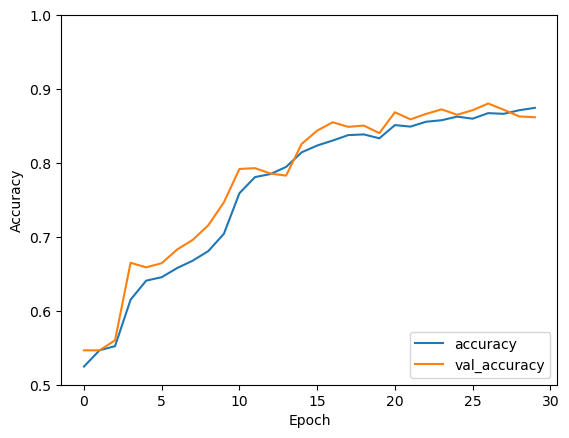

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(valid_generator, verbose=2)

plt.savefig(result_root+'vgg16_accuracy_after_tiling_augmentation.png')